In [1]:
'''
=====Experiment=====
Dataset: UNSW-NB15 dataset

Training in chronological window subgraph
Downsample 90% normal traffic stratigically
Split train and test subgraph stratigically 

IP + Port number as node
'''

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.loader import NeighborSampler
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# import seaborn as sns
# import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Datasets.UNSW_NB15.UNSW_NB15_config import UNSW_NB15_Config

In [ ]:
csv_file_name = "all_raw"

data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))

DATASET_NAME = "UNSW_NB15"
EXPERIMENT_NAME = "window_combined_port"

SOURCE_FILE_ID_COL_NAME = UNSW_NB15_Config.SOURCE_FILE_ID_COL_NAME

SOURCE_IP_COL_NAME = UNSW_NB15_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = UNSW_NB15_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = UNSW_NB15_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = UNSW_NB15_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = UNSW_NB15_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = UNSW_NB15_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = UNSW_NB15_Config.BENIGN_CLASS_NAME

TIME_COLS = UNSW_NB15_Config.TIME_COL_NAMES

CATEGORICAL_COLS = UNSW_NB15_Config.CATEGORICAL_COLS

print(data[ATTACK_CLASS_COL_NAME].value_counts())
print(data[IS_ATTACK_COL_NAME].value_counts())

MULTICLASS = True

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
    data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
else:
    label_col = IS_ATTACK_COL_NAME
    data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)


saves_path = os.path.join(project_root, "Models/E_GraphSAGE/logs", DATASET_NAME, EXPERIMENT_NAME)

checkpoint_path = os.path.join(saves_path, f"checkpoints_{csv_file_name}.pth")
best_model_path = os.path.join(saves_path, f"best_model_{csv_file_name}.pth")

os.makedirs(saves_path, exist_ok=True)

/tmp/ipykernel_3159083/1266473344.py:3: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(project_root, "Datasets", f"UNSW_NB15/All/{csv_file_name}.csv"))


attack_cat
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoors            2329
Shellcode            1511
Worms                 174
Name: count, dtype: int64
label
0    2218764
1     321283
Name: count, dtype: int64


In [3]:
data.drop(columns=UNSW_NB15_Config.DROP_COLS,inplace=True)
print(data.columns)

Index(['srcip', 'sport', 'dstip', 'dsport', 'state', 'dur', 'sbytes', 'dbytes',
       'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
       'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
       'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',
       'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl',
       'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src',
       'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'source_file_id'],
      dtype='object')


In [ ]:
data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data

data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

# Port category encoding: 
def port_category(port_str):
    try:
        port_int = int(port_str)
        if 1 <= port_int <= 1023:
            return [1, 0, 0]  # Well Known
        elif 1024 <= port_int <= 49151:
            return [0, 1, 0]  # Registered
        elif 49152 <= port_int <= 65535:
            return [0, 0, 1]  # Dynamic/Private
        else:
            return [0, 0, 0]  # Out of range, encode as all zeros
    except:
        return [0, 0, 0]  # Non-integer or missing, encode as all zeros

# Create new columns for binary encoding
src_port_category = data[SOURCE_PORT_COL_NAME].apply(port_category)
dst_port_category = data[DESTINATION_PORT_COL_NAME].apply(port_category)

src_port_category_df = pd.DataFrame(src_port_category.tolist(), columns=[f"{SOURCE_PORT_COL_NAME}_category_{i}" for i in range(3)])
dst_port_category_df = pd.DataFrame(dst_port_category.tolist(), columns=[f"{DESTINATION_PORT_COL_NAME}_category_{i}" for i in range(3)])

# Concatenate the binary columns to the original dataframe
data = pd.concat([data, src_port_category_df, dst_port_category_df], axis=1)

data.drop(columns=[SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME], inplace=True)

converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]))]

In [5]:
print(data.head)

<bound method NDFrame.head of                        srcip                    dstip state        dur  \
0            10.40.182.1_0:0            224.0.0.5_0:0   INT  50.004337   
1             10.40.85.1_0:0            224.0.0.5_0:0   INT  50.004341   
2            10.40.182.1_0:0            224.0.0.5_0:0   INT  50.004337   
3             10.40.85.1_0:0            224.0.0.5_0:0   INT  50.004341   
4        192.168.241.243_0:0  192.168.241.243_0:49320   URH   0.000000   
...                      ...                      ...   ...        ...   
2540042       59.166.0.0_3:0       149.171.126.5_3:53   CON   0.001035   
2540043       59.166.0.5_3:0    149.171.126.3_3:30639   FIN   0.220630   
2540044       59.166.0.6_3:0    149.171.126.7_3:35667   FIN   0.031576   
2540045       59.166.0.2_3:0    149.171.126.7_3:64122   FIN   0.096835   
2540046       59.166.0.9_3:0       149.171.126.7_3:25   FIN   0.201886   

         sbytes  dbytes  sttl  dttl  sloss  dloss  ...  ct_ftp_cmd  \
0          

In [ ]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)
data.fillna(0,inplace = True)
data.drop(columns=['index'],inplace=True)
print(data.head)

<bound method NDFrame.head of                        srcip                    dstip        dur  sbytes  \
0            10.40.182.1_0:0            224.0.0.5_0:0  50.004337     384   
1             10.40.85.1_0:0            224.0.0.5_0:0  50.004341     384   
2            10.40.182.1_0:0            224.0.0.5_0:0  50.004337     384   
3             10.40.85.1_0:0            224.0.0.5_0:0  50.004341     384   
4        192.168.241.243_0:0  192.168.241.243_0:49320   0.000000    1780   
...                      ...                      ...        ...     ...   
2540042       59.166.0.0_3:0       149.171.126.5_3:53   0.001035     146   
2540043       59.166.0.5_3:0    149.171.126.3_3:30639   0.220630     424   
2540044       59.166.0.6_3:0    149.171.126.7_3:35667   0.031576    2646   
2540045       59.166.0.2_3:0    149.171.126.7_3:64122   0.096835    4862   
2540046       59.166.0.9_3:0       149.171.126.7_3:25   0.201886   37552   

         dbytes  sttl  dttl  sloss  dloss         Sload  

In [8]:
scaler = StandardScaler()
cols_to_norm = UNSW_NB15_Config.COLS_TO_NORM
print(data[cols_to_norm].describe()) # Check if there's any too large value

                dur        sbytes        dbytes          sttl          dttl  \
count  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06   
mean   6.587916e-01  4.339600e+03  3.642759e+04  6.278197e+01  3.076681e+01   
std    1.392493e+01  5.640599e+04  1.610960e+05  7.462277e+01  4.285089e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.037000e-03  2.000000e+02  1.780000e+02  3.100000e+01  2.900000e+01   
50%    1.586100e-02  1.470000e+03  1.820000e+03  3.100000e+01  2.900000e+01   
75%    2.145545e-01  3.182000e+03  1.489400e+04  3.100000e+01  2.900000e+01   
max    8.786638e+03  1.435577e+07  1.465753e+07  2.550000e+02  2.540000e+02   

              sloss         dloss         Sload         Dload         Spkts  \
count  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06  2.540047e+06   
mean   5.163921e+00  1.632944e+01  3.695645e+07  2.450861e+06  3.328884e+01   
std    2.251707e+01  5.659474e+01  1.186043e+08  4.

In [9]:
def check_numeric_issues(df, cols_to_norm):
    for col in cols_to_norm:
        try:
            # Try to coerce to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Try to clip the column
            df[col] = df[col].clip(lower=-1e9, upper=1e9)
            
        except Exception as e:
            print(f"❌ Column '{col}' failed with error: {e}")
            print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
            print(f"  - Data type: {df[col].dtype}")
            continue

    print("\n✅ All other columns processed successfully.")

check_numeric_issues(data, UNSW_NB15_Config.COLS_TO_NORM)


✅ All other columns processed successfully.


In [10]:
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [11]:
from sklearn.preprocessing import LabelEncoder

num_classes = 2
class_map = [0, 1]
if MULTICLASS:
    le = LabelEncoder()
    attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
    class_map = le.classes_
    print(class_map)
    print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
    data[ATTACK_CLASS_COL_NAME] = attack_labels
    num_classes = len(class_map)
    class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
ADVERSARIAL_CLASS_LABEL = len(class_map)

['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
Attack label mapping: {'Analysis': 0, 'Backdoors': 1, 'DoS': 2, 'Exploits': 3, 'Fuzzers': 4, 'Generic': 5, 'Normal': 6, 'Reconnaissance': 7, 'Shellcode': 8, 'Worms': 9}


In [12]:
# # Maintain the order of the rows in the original dataframe

feature_cols = UNSW_NB15_Config.COLS_TO_NORM + converted_categorical_cols

print('Feature Columns:', feature_cols)
num_features = len(feature_cols)
print('Number of Features:', num_features)

data['h'] = data[ feature_cols ].values.tolist()

Feature Columns: ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'state_ACC', 'state_CLO', 'state_CON', 'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS', 'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD', 'state_URH', 'state_URN', 'state_no']
Number of Features: 54


In [13]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [15]:
from collections import defaultdict
import heapq

import tqdm

class Downsampler:
    def __init__(self, downsample_classes=[BENIGN_CLASS_LABEL], downsample_ratios=[0.1]):
        """
        downsample_classes: list of class names to downsample
        downsample_ratio: keep no more than this ratio for each class
        """
        assert len(downsample_classes) == len(downsample_ratios)
        self.downsample_classes = downsample_classes
        self.downsample_ratio = downsample_ratios

    def downsample(self, label_counts_list, X, y):
        total_counts = defaultdict(int)

        class_heaps = defaultdict(list)
        for i, lc in enumerate(label_counts_list):
            for cls in self.downsample_classes:
                class_label_count = lc.get(cls, 0)
                total_counts[cls] += class_label_count
                heapq.heappush(class_heaps[cls], (-class_label_count, i))

        class_target = {
            cls: total_counts[cls] * self.downsample_ratio[i] for i, cls in enumerate(self.downsample_classes)
        }
                
        indices_to_remove = set()
        class_counts = total_counts

        # 3. For each class, remove top contributing samples until threshold reached
        for cls in self.downsample_classes:
            target = class_target[cls]
            heap = class_heaps[cls]

            pbar = tqdm(desc=f"Downsampling '{cls}'", total=len(heap))
            while class_counts[cls] > target and heap:
                _, idx = heapq.heappop(heap)
                if idx in indices_to_remove:
                    continue
                # For each class in this sample, if it's a downsample class, decrement the count
                for sample_cls, count in label_counts_list[idx].items():
                    if sample_cls in self.downsample_classes:
                        class_counts[sample_cls] -= count
                indices_to_remove.add(idx)
                pbar.update(1)
                pbar.set_postfix(class_label=cls, remaining=class_counts[cls], target=target)
            pbar.close()

        # 4. Apply filter
        keep_mask = [i for i in range(len(X)) if i not in indices_to_remove]
        X_new = [X[i] for i in keep_mask]
        y_new = [y[i] for i in keep_mask]

        return X_new, y_new

downsampler = Downsampler()

In [ ]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g


def generate_graph_datasets(
    df: pd.DataFrame, 
    window_size: int = 200, 
    # overlap_ratio: float = 0, 
    feature_cols=feature_cols,
    ordering_cols=[SOURCE_FILE_ID_COL_NAME] + TIME_COLS + [ATTACK_CLASS_COL_NAME], 
    label_col=label_col,
    build_graph_func=create_graph,
    downsampler=downsampler
    ):

    print("All Columns: ", df.columns)
    print("Ordering Columns: ", ordering_cols)
    assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
    assert label_col in df.columns, "Edge label column 'label' is required"
    
    df = df.sort_values(ordering_cols).reset_index(drop=True)
    window_size = int(window_size)
    
    df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

    print("Final Columns: ", df.columns)
    
    label_counts_list = []
    X = []
    y = []

    progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
    for start in progress_bar:
        window_df = df[start: min(start + window_size, len(df))]
        contains_label = window_df[label_col].unique()

        G_pyg = build_graph_func(window_df)

        label_counts = window_df[label_col].value_counts()

        label_counts_list.append(label_counts)
        X.append(G_pyg)
        y.append(contains_label.tolist())

    X, y = downsampler.downsample(label_counts_list, X, y)
        
    return StratifiedGraphDataset(X, y)

In [17]:
graph_dataset = generate_graph_datasets(data)
full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)


All Columns:  Index(['srcip', 'dstip', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss',
       'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
       'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
       'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
       'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm',
       'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'attack_cat', 'source_file_id', 'state_ACC', 'state_CLO', 'state_CON',
       'state_ECO', 'state_ECR', 'state_FIN', 'state_INT', 'state_MAS',
       'state_PAR', 'state_REQ', 'state_RST', 'state_TST', 'state_TXD',
       'state_URH', 'state_URN', 'state_no', 'h'],
      dtype='object')
Ordering Columns:  ['source_file_id', 'Stime', 'Ltime', 'attack_cat']
Final Columns:  Index(['srcip', 'dstip', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 's

Downsampling '6':  85%|████████▌ | 10853/12701 [00:10<00:01, 1035.40it/s, class_label=6, remaining=221852, target=2.22e+5]


In [18]:
print("Class Distrubution:", data[label_col].value_counts())

print("Number of graphs after downsampling:", len(graph_dataset))
graph_dataset.print_class_distribution_and_weights()
print("Number of training graphs:", len(full_train_graph_dataset))
full_train_graph_dataset.print_class_distribution_and_weights()
print("Number of testing graphs:", len(test_graph_dataset))
test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: attack_cat
6    2218764
5     215481
3      44525
4      24246
2      16353
7      13987
0       2677
1       2329
8       1511
9        174
Name: count, dtype: int64
Number of graphs after downsampling: 1848
Class Counts and Weights:
6   Normal         : Count = 221852    , Weight = 0.1665    
5   Generic        : Count = 105186    , Weight = 0.3512    
3   Exploits       : Count = 17858     , Weight = 2.0688    
0   Analysis       : Count = 2083      , Weight = 17.7363   
1   Backdoors      : Count = 1818      , Weight = 20.3216   
2   DoS            : Count = 11800     , Weight = 3.1309    
4   Fuzzers        : Count = 5177      , Weight = 7.1363    
7   Reconnaissance : Count = 3401      , Weight = 10.8629   
9   Worms          : Count = 41        , Weight = 901.0902  
8   Shellcode      : Count = 231       , Weight = 159.9338  
Number of training graphs: 1570
Class Counts and Weights:
6   Normal         : Count = 188281    , Weight = 0.1667    
5   Generic     

In [19]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_msg = nn.Linear(in_channels + edge_dim, out_channels)
        self.W_apply = nn.Linear(in_channels + out_channels, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: features of source nodes (neighbours)
        msg_input = th.cat([x_j, edge_attr], dim=1)
        return self.W_msg(msg_input)

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [20]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
th.cuda.empty_cache()

In [22]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)



In [ ]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def grid_search(graph_dataset, epochs, learning_rates, hidden_dims, folds=3):
    global num_features
    
    best_params = {}
    best_f1 = 0

    # Precompute the train and validation graphs for all folds
    folds_list = []
    for i in range(folds):
        train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
        folds_list.append((train_graph_dataset, val_graph_dataset))

    params_results = {}
    for lr in learning_rates:
        for hidden_dim in hidden_dims:
            for drop_out in drop_outs:
                print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}")
                fold_f1_scores = []

                for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                    print(f"Fold {fold + 1}")

                    model = EGraphSAGE(node_in_channels=num_features,
                                    edge_in_channels=num_features,
                                    hidden_channels=hidden_dim,
                                    dropout = drop_out,
                                    out_channels=num_classes).to(device)

                    model.apply(init_weights)

                    # Normalize to stabilize training
                    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                    print("Class weights:", class_weights)

                    criterion = nn.CrossEntropyLoss(weight=class_weights)
                    optimizer = th.optim.Adam(model.parameters(), lr=lr)

                    best_epoch_f1 = 0  # Track the best F1 score for this fold

                    for epoch in range(epochs):
                        try:
                            total_train_loss = 0
                            total_val_loss = 0

                            model.train()
                            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):
                                G_pyg_train = G_pyg_train.to(device)

                                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                
                                out = model(G_pyg_train)
                                loss = criterion(out, G_pyg_train.edge_label)
                                total_train_loss += loss.item()

                                optimizer.zero_grad()
                                loss.backward()

                                optimizer.step()
                            
                            model.eval()
                            total_f1 = 0
                            with th.no_grad():
                                for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                    G_pyg_val.to(device)
                                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                    out = model(G_pyg_val)
                                    loss = criterion(out, G_pyg_val.edge_label)
                                    total_val_loss += loss.item()

                                    total_f1 += f1_score(G_pyg_val.edge_label.cpu(), out.argmax(dim=1).cpu(), average='weighted')

                            avg_f1 = total_f1 / len(val_graph_dataset)
                            if avg_f1 > best_epoch_f1:
                                best_epoch_f1 = avg_f1  # Update the best F1 score for this fold
                                print(f"Best F1 Score at epoch {epoch}: {best_epoch_f1:.4f}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Parameters: lr={lr}, hidden_dim{hidden_dim}, drop_out={drop_out}")

                            print(f'Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation F1: {avg_f1:.4f}')

                        except Exception as e:
                            print(f"An error occurred at epoch {epoch}: {str(e)}")
                            break

                    fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                
                avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                if avg_f1 > best_f1:
                    best_f1 = avg_f1
                    best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

    print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
    print("All results:", params_results)


learning_rates = [0.001, 0.005, 0.01]
hidden_dims = [128, 256, 512]
drop_outs = [0.2, 0.3, 0.4]

# grid_search(full_train_graph_dataset, epochs=10, learning_rates=learning_rates, hidden_dims=hidden_dims, drop_outs=drop_outs)


In [24]:
train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [30]:
# Extract the best parameters from the grid search
import pickle


best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.001  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found

print("Number of train graphs: ", len(train_graph_dataset))

# Initialize the model with the best parameters
model = EGraphSAGE(node_in_channels=num_features, 
                   edge_in_channels=num_features,
                   hidden_channels=best_hidden_dim,
                   dropout = best_drop_out,
                   out_channels=num_classes).to(device)

model.apply(init_weights)

# Normalize class weights
class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
print("Class weights:", class_weights)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)

# ===== Load checkpoint if exists =====
best_f1 = 0
start_epoch = 0
epochs = 1000

if os.path.exists(checkpoint_path):
    checkpoint = th.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    print(f"Resumed training from epoch {start_epoch}")

train_loss_history = []
val_loss_history = []
val_f1_history = []
saved_model_epochs = []

train_loss_history_path = os.path.join(saves_path, 'train_loss_history.pkl')
val_loss_history_path = os.path.join(saves_path, 'val_loss_history.pkl')
val_f1_history_path = os.path.join(saves_path, 'val_f1_history.pkl')
saved_model_epochs_path = os.path.join(saves_path, 'saved_model_epochs.pkl')

if os.path.exists(train_loss_history_path) and os.path.exists(val_loss_history_path) and os.path.exists(val_f1_history_path) and os.path.exists(saved_model_epochs_path):
    with open(train_loss_history_path, 'rb') as f:
        train_loss_history = pickle.load(f)
    with open(val_loss_history_path, 'rb') as f:
        val_loss_history = pickle.load(f)
    with open(val_f1_history_path, 'rb') as f:
        val_f1_history = pickle.load(f)
    with open(saved_model_epochs_path, 'rb') as f:
        saved_model_epochs = pickle.load(f)

# ===== Start Training =====
for epoch in range(start_epoch, epochs):
    model.train()

    train_loss = 0
    val_loss = 0

    for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

        # Move the graph data to the device
        G_pyg_train = G_pyg_train.to(device)
        G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
        G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

        optimizer.zero_grad()
        out = model(G_pyg_train)
        loss = criterion(out, G_pyg_train.edge_label)
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    test_label_list = []
    pred_label_list = []

    model.eval()
    with th.no_grad():
        for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
            G_pyg_val = G_pyg_val.to(device)
            G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
            G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

            out = model(G_pyg_val)
            loss = criterion(out, G_pyg_val.edge_label)
            val_loss += loss.item()

            test_label_list.append(G_pyg_val.edge_label.cpu())
            pred_label_list.append(out.argmax(dim=1).cpu())

    test_label = th.cat(test_label_list)
    pred_label = th.cat(pred_label_list)

    val_f1 = f1_score(test_label, pred_label, average='weighted')
    val_f1_micro = f1_score(test_label, pred_label, average='micro')
    val_f1_macro = f1_score(test_label, pred_label, average='macro')

    if epoch % 10 == 0 or val_f1 > best_f1:
        # Save checkpoint
        th.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_f1': best_f1
        }, checkpoint_path)
        with open(train_loss_history_path, 'wb') as f:
            pickle.dump(train_loss_history, f)
        with open(val_loss_history_path, 'wb') as f:
            pickle.dump(val_loss_history, f)
        with open(val_f1_history_path, 'wb') as f:
            pickle.dump(val_f1_history, f)
        with open(saved_model_epochs_path, 'wb') as f:
            pickle.dump(saved_model_epochs, f)

    if val_f1 > best_f1:
        best_f1 = val_f1  # Update the best F1 score for this fold
        best_model_state = model.state_dict()
        th.save(best_model_state, best_model_path)
        print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)
        saved_model_epochs.append(epoch)

    if epoch % 1 == 0:
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}')

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

# Save the trained model
print("Model training completed and saved.")

Number of train graphs:  1334
Class weights: tensor([1.8187e+01, 2.1024e+01, 3.0260e+00, 2.0663e+00, 7.5452e+00, 3.5045e-01,
        1.6674e-01, 1.0824e+01, 1.5976e+02, 8.8933e+02], device='cuda:0')


Training:   0%|          | 0/1334 [00:00<?, ?it/s]

Epoch 0 Saved best model. Best F1: 0.8771301370598615
Epoch 0, Train Loss: 1324.5085, Validation Loss: 342.9918, Validation F1: 0.8771


Epoch 1 Saved best model. Best F1: 0.8954226904474545
Epoch 1, Train Loss: 1130.4649, Validation Loss: 256.8245, Validation F1: 0.8954


Epoch 2, Train Loss: 1086.5474, Validation Loss: 244.9469, Validation F1: 0.8952


Epoch 3, Train Loss: 1044.6391, Validation Loss: 234.0098, Validation F1: 0.8954


Epoch 4 Saved best model. Best F1: 0.8955935813981343
Epoch 4, Train Loss: 1057.9669, Validation Loss: 231.6792, Validation F1: 0.8956


Epoch 5 Saved best model. Best F1: 0.8968707721232875
Epoch 5, Train Loss: 1015.7576, Validation Loss: 228.2052, Validation F1: 0.8969


Epoch 6, Train Loss: 996.6131, Validation Loss: 219.6210, Validation F1: 0.8939


Epoch 7, Train Loss: 966.6464, Validation Loss: 210.8428, Validation F1: 0.8950


Epoch 8, Train Loss: 1070.2116, Validation Loss: 202.8115, Validation F1: 0.8940


Epoch 9, Train Loss: 1015.1235, Validation Loss: 198.3379, Validation F1: 0.8927


Epoch 10, Train Loss: 962.9804, Validation Loss: 217.4444, Validation F1: 0.8940


Epoch 11, Train Loss: 1034.2977, Validation Loss: 211.4781, Validation F1: 0.8942


Epoch 12 Saved best model. Best F1: 0.8997075895022664
Epoch 12, Train Loss: 953.2851, Validation Loss: 216.1348, Validation F1: 0.8997


Epoch 13, Train Loss: 934.5385, Validation Loss: 240.9384, Validation F1: 0.8955


Epoch 14 Saved best model. Best F1: 0.8998841259020989
Epoch 14, Train Loss: 921.6980, Validation Loss: 215.7538, Validation F1: 0.8999


Epoch 15 Saved best model. Best F1: 0.9045977533364328
Epoch 15, Train Loss: 896.9613, Validation Loss: 182.0959, Validation F1: 0.9046


Epoch 16, Train Loss: 905.2825, Validation Loss: 188.3129, Validation F1: 0.8960


Epoch 17, Train Loss: 915.8817, Validation Loss: 183.8148, Validation F1: 0.8967


Epoch 18, Train Loss: 885.1593, Validation Loss: 196.5994, Validation F1: 0.8955


Epoch 19, Train Loss: 876.4130, Validation Loss: 179.4382, Validation F1: 0.8965


Epoch 20, Train Loss: 889.3201, Validation Loss: 240.7478, Validation F1: 0.9033


Epoch 21, Train Loss: 881.7117, Validation Loss: 218.9534, Validation F1: 0.8961


Epoch 22, Train Loss: 886.4459, Validation Loss: 214.7629, Validation F1: 0.8974


Epoch 23 Saved best model. Best F1: 0.9072205245797452
Epoch 23, Train Loss: 886.7662, Validation Loss: 210.3637, Validation F1: 0.9072


Epoch 24, Train Loss: 853.6132, Validation Loss: 200.6892, Validation F1: 0.8978


Epoch 25, Train Loss: 871.2416, Validation Loss: 197.4749, Validation F1: 0.9001


Epoch 26, Train Loss: 857.2107, Validation Loss: 196.0856, Validation F1: 0.8960


Epoch 27, Train Loss: 864.4915, Validation Loss: 214.9975, Validation F1: 0.8994


Epoch 28, Train Loss: 888.0555, Validation Loss: 213.7885, Validation F1: 0.8967


Epoch 29, Train Loss: 855.5010, Validation Loss: 227.1225, Validation F1: 0.8973


Epoch 30, Train Loss: 840.4035, Validation Loss: 292.1472, Validation F1: 0.8973


Epoch 31, Train Loss: 862.7953, Validation Loss: 206.5532, Validation F1: 0.8958


Epoch 32, Train Loss: 844.8618, Validation Loss: 225.8697, Validation F1: 0.9041


Epoch 33, Train Loss: 861.6915, Validation Loss: 228.6933, Validation F1: 0.9000


Epoch 34, Train Loss: 832.3936, Validation Loss: 308.3765, Validation F1: 0.8981


Epoch 35, Train Loss: 896.7534, Validation Loss: 237.0559, Validation F1: 0.8973


Epoch 36, Train Loss: 847.7542, Validation Loss: 298.2983, Validation F1: 0.9019


Epoch 37, Train Loss: 821.5320, Validation Loss: 246.8924, Validation F1: 0.9025


Epoch 38, Train Loss: 839.8467, Validation Loss: 259.3592, Validation F1: 0.8957


Epoch 39, Train Loss: 826.3360, Validation Loss: 286.0078, Validation F1: 0.9009


Epoch 40, Train Loss: 840.7505, Validation Loss: 253.0198, Validation F1: 0.8962


Epoch 41, Train Loss: 823.2018, Validation Loss: 306.8036, Validation F1: 0.8985


Epoch 42, Train Loss: 832.7258, Validation Loss: 304.2767, Validation F1: 0.8973


Epoch 43 Saved best model. Best F1: 0.9080173264179365
Epoch 43, Train Loss: 853.7559, Validation Loss: 267.9768, Validation F1: 0.9080


Epoch 44 Saved best model. Best F1: 0.9100937574970086
Epoch 44, Train Loss: 829.8940, Validation Loss: 350.8729, Validation F1: 0.9101


Epoch 45, Train Loss: 848.7033, Validation Loss: 280.0938, Validation F1: 0.8976


Epoch 46, Train Loss: 818.4012, Validation Loss: 239.6713, Validation F1: 0.9093


Epoch 47, Train Loss: 837.8134, Validation Loss: 249.2444, Validation F1: 0.8974


Epoch 48, Train Loss: 832.2459, Validation Loss: 314.8178, Validation F1: 0.9025


Epoch 49, Train Loss: 800.4186, Validation Loss: 271.9334, Validation F1: 0.9046


Epoch 50, Train Loss: 821.7696, Validation Loss: 286.1723, Validation F1: 0.9076


Epoch 51, Train Loss: 819.2763, Validation Loss: 354.2724, Validation F1: 0.8995


Epoch 52, Train Loss: 833.3395, Validation Loss: 329.8134, Validation F1: 0.8989


Epoch 53, Train Loss: 812.8056, Validation Loss: 404.1391, Validation F1: 0.8991


Epoch 54, Train Loss: 826.2146, Validation Loss: 334.9027, Validation F1: 0.9036


Epoch 55, Train Loss: 806.1662, Validation Loss: 325.2638, Validation F1: 0.9004


Epoch 56, Train Loss: 810.8485, Validation Loss: 377.0182, Validation F1: 0.9076


Epoch 57, Train Loss: 823.9131, Validation Loss: 251.2983, Validation F1: 0.8982


Epoch 58, Train Loss: 817.1936, Validation Loss: 226.0582, Validation F1: 0.8972


Epoch 59, Train Loss: 804.4730, Validation Loss: 318.2025, Validation F1: 0.8975


Epoch 60 Saved best model. Best F1: 0.910390138326152
Epoch 60, Train Loss: 783.2973, Validation Loss: 347.9808, Validation F1: 0.9104


Epoch 61, Train Loss: 798.9785, Validation Loss: 323.7764, Validation F1: 0.8971


Epoch 62, Train Loss: 834.8255, Validation Loss: 318.3788, Validation F1: 0.9060


Epoch 63, Train Loss: 798.2750, Validation Loss: 274.8001, Validation F1: 0.8999


Epoch 64, Train Loss: 816.1156, Validation Loss: 265.5188, Validation F1: 0.9044


Epoch 65, Train Loss: 784.8108, Validation Loss: 321.5632, Validation F1: 0.8981


Epoch 66, Train Loss: 825.4525, Validation Loss: 315.6822, Validation F1: 0.9050


Epoch 67, Train Loss: 814.1006, Validation Loss: 236.8301, Validation F1: 0.9008


Epoch 68, Train Loss: 785.1308, Validation Loss: 246.1500, Validation F1: 0.9029


Epoch 69, Train Loss: 793.7673, Validation Loss: 245.8364, Validation F1: 0.9041


Epoch 70, Train Loss: 807.6032, Validation Loss: 297.4601, Validation F1: 0.9085


Epoch 71, Train Loss: 813.4502, Validation Loss: 307.9749, Validation F1: 0.9065


Epoch 72, Train Loss: 769.6619, Validation Loss: 300.5418, Validation F1: 0.8986


Epoch 73, Train Loss: 795.0055, Validation Loss: 284.2359, Validation F1: 0.9025


Epoch 74, Train Loss: 813.8236, Validation Loss: 290.0328, Validation F1: 0.9024


Epoch 75, Train Loss: 809.3998, Validation Loss: 277.8413, Validation F1: 0.8999


Epoch 76, Train Loss: 837.6280, Validation Loss: 262.5323, Validation F1: 0.8965


Epoch 77, Train Loss: 829.0985, Validation Loss: 325.7240, Validation F1: 0.8971


Epoch 78, Train Loss: 795.8336, Validation Loss: 242.7033, Validation F1: 0.9024


Epoch 79, Train Loss: 819.0516, Validation Loss: 279.9550, Validation F1: 0.9066


Epoch 80, Train Loss: 794.5606, Validation Loss: 296.0159, Validation F1: 0.9020


Epoch 81, Train Loss: 784.4647, Validation Loss: 265.8341, Validation F1: 0.9074


Epoch 82, Train Loss: 786.0158, Validation Loss: 376.1976, Validation F1: 0.8996


Epoch 83, Train Loss: 826.3527, Validation Loss: 251.8087, Validation F1: 0.8959


Epoch 84, Train Loss: 803.0888, Validation Loss: 255.3150, Validation F1: 0.8995


Epoch 85, Train Loss: 805.3427, Validation Loss: 687.2259, Validation F1: 0.9061


Epoch 86, Train Loss: 793.8443, Validation Loss: 561.4092, Validation F1: 0.9022


Epoch 87, Train Loss: 804.8600, Validation Loss: 622.3088, Validation F1: 0.9012


Epoch 88, Train Loss: 816.7387, Validation Loss: 769.4601, Validation F1: 0.8976


Epoch 89, Train Loss: 781.8500, Validation Loss: 613.1665, Validation F1: 0.9060


Epoch 90, Train Loss: 799.1778, Validation Loss: 651.8989, Validation F1: 0.9021


Epoch 91, Train Loss: 797.4040, Validation Loss: 486.0631, Validation F1: 0.9041


Epoch 92 Saved best model. Best F1: 0.9107456947410929
Epoch 92, Train Loss: 835.8726, Validation Loss: 440.1049, Validation F1: 0.9107


Epoch 93, Train Loss: 779.3581, Validation Loss: 466.3920, Validation F1: 0.9048


Epoch 94, Train Loss: 808.4484, Validation Loss: 408.0291, Validation F1: 0.9027


Epoch 95, Train Loss: 780.4558, Validation Loss: 547.7215, Validation F1: 0.9082


Epoch 96, Train Loss: 829.5330, Validation Loss: 450.5027, Validation F1: 0.9098


Epoch 97, Train Loss: 820.8653, Validation Loss: 436.2281, Validation F1: 0.9040


Epoch 98, Train Loss: 806.0651, Validation Loss: 637.7152, Validation F1: 0.8972


Epoch 99, Train Loss: 818.1688, Validation Loss: 490.2358, Validation F1: 0.8954


Epoch 100, Train Loss: 831.0614, Validation Loss: 572.8751, Validation F1: 0.9042


Epoch 101, Train Loss: 791.8749, Validation Loss: 577.7336, Validation F1: 0.9034


Epoch 102, Train Loss: 796.6253, Validation Loss: 534.9761, Validation F1: 0.8994


Epoch 103, Train Loss: 804.2915, Validation Loss: 779.3875, Validation F1: 0.9028


Epoch 104, Train Loss: 815.8102, Validation Loss: 653.2952, Validation F1: 0.8961


Epoch 105, Train Loss: 804.4993, Validation Loss: 720.8168, Validation F1: 0.8977


Epoch 106, Train Loss: 829.6888, Validation Loss: 767.1936, Validation F1: 0.8948


Epoch 107, Train Loss: 776.9390, Validation Loss: 668.5666, Validation F1: 0.8997


Epoch 108, Train Loss: 798.0623, Validation Loss: 812.8402, Validation F1: 0.9018


Epoch 109, Train Loss: 831.8443, Validation Loss: 805.5783, Validation F1: 0.9070


Epoch 110, Train Loss: 860.2853, Validation Loss: 665.5893, Validation F1: 0.8944


Epoch 111, Train Loss: 814.8428, Validation Loss: 510.0593, Validation F1: 0.8977


Epoch 112, Train Loss: 807.6164, Validation Loss: 631.4110, Validation F1: 0.8965


Epoch 113, Train Loss: 837.7385, Validation Loss: 551.9591, Validation F1: 0.9025


Epoch 114, Train Loss: 785.5571, Validation Loss: 628.7426, Validation F1: 0.9004


Epoch 115, Train Loss: 783.9538, Validation Loss: 493.0315, Validation F1: 0.8969


Epoch 116, Train Loss: 823.7267, Validation Loss: 688.0553, Validation F1: 0.9024


Epoch 117, Train Loss: 873.1111, Validation Loss: 409.9802, Validation F1: 0.9032


Epoch 118, Train Loss: 789.6461, Validation Loss: 550.3750, Validation F1: 0.8991


Epoch 119, Train Loss: 841.0811, Validation Loss: 414.0830, Validation F1: 0.8971


Epoch 120, Train Loss: 810.1976, Validation Loss: 512.9473, Validation F1: 0.8985


Epoch 121, Train Loss: 790.1554, Validation Loss: 493.9060, Validation F1: 0.9004


Epoch 122, Train Loss: 810.4405, Validation Loss: 486.9883, Validation F1: 0.9034


Epoch 123, Train Loss: 791.6555, Validation Loss: 571.2974, Validation F1: 0.9065


Epoch 124, Train Loss: 807.0485, Validation Loss: 579.1397, Validation F1: 0.8999


Epoch 125, Train Loss: 807.6176, Validation Loss: 601.3295, Validation F1: 0.9013


Epoch 126, Train Loss: 830.9043, Validation Loss: 406.0085, Validation F1: 0.9060


Epoch 127, Train Loss: 838.4098, Validation Loss: 465.8778, Validation F1: 0.8961


Epoch 128, Train Loss: 801.2532, Validation Loss: 554.5226, Validation F1: 0.8956


Epoch 129, Train Loss: 808.7690, Validation Loss: 423.2938, Validation F1: 0.8964


Epoch 130, Train Loss: 786.3843, Validation Loss: 542.5836, Validation F1: 0.9018


Epoch 131, Train Loss: 807.7267, Validation Loss: 648.4602, Validation F1: 0.9002


Epoch 132, Train Loss: 865.0238, Validation Loss: 461.3296, Validation F1: 0.8964


Epoch 133, Train Loss: 805.6198, Validation Loss: 303.9578, Validation F1: 0.8985


Epoch 134, Train Loss: 786.5606, Validation Loss: 351.8492, Validation F1: 0.8971


Epoch 135, Train Loss: 778.6792, Validation Loss: 411.1310, Validation F1: 0.8978


Epoch 136, Train Loss: 841.4184, Validation Loss: 391.7230, Validation F1: 0.9014


Epoch 137, Train Loss: 800.1911, Validation Loss: 498.0287, Validation F1: 0.8955


Epoch 138, Train Loss: 844.9710, Validation Loss: 408.9752, Validation F1: 0.9048


Epoch 139, Train Loss: 861.2213, Validation Loss: 489.4427, Validation F1: 0.8967


Epoch 140, Train Loss: 780.6492, Validation Loss: 587.0462, Validation F1: 0.9019


Epoch 141, Train Loss: 800.6109, Validation Loss: 453.1676, Validation F1: 0.8959


Epoch 142, Train Loss: 811.8063, Validation Loss: 406.7030, Validation F1: 0.9032


Epoch 143, Train Loss: 824.6138, Validation Loss: 465.4630, Validation F1: 0.9044


Epoch 144, Train Loss: 796.2422, Validation Loss: 482.6336, Validation F1: 0.8981


Epoch 145, Train Loss: 811.4344, Validation Loss: 517.5190, Validation F1: 0.9054


Epoch 146, Train Loss: 799.2034, Validation Loss: 551.8961, Validation F1: 0.8993


Epoch 147, Train Loss: 854.4036, Validation Loss: 544.5668, Validation F1: 0.9070


Epoch 148, Train Loss: 826.0367, Validation Loss: 426.8923, Validation F1: 0.8985


Epoch 149, Train Loss: 846.8686, Validation Loss: 639.8235, Validation F1: 0.9067


Epoch 150, Train Loss: 839.3921, Validation Loss: 442.7540, Validation F1: 0.9057


Epoch 151, Train Loss: 796.9534, Validation Loss: 495.3080, Validation F1: 0.8998


Epoch 152, Train Loss: 878.3870, Validation Loss: 459.4996, Validation F1: 0.8956


Epoch 153, Train Loss: 804.0047, Validation Loss: 558.2300, Validation F1: 0.9088


Epoch 154, Train Loss: 1015.7198, Validation Loss: 674.4899, Validation F1: 0.9070


Epoch 155, Train Loss: 1073.9763, Validation Loss: 718.6447, Validation F1: 0.9102


Epoch 156, Train Loss: 807.9819, Validation Loss: 604.2362, Validation F1: 0.9046


Epoch 157, Train Loss: 828.0066, Validation Loss: 540.5152, Validation F1: 0.9068


Epoch 158, Train Loss: 833.3481, Validation Loss: 702.3263, Validation F1: 0.8986


Epoch 159, Train Loss: 797.4704, Validation Loss: 696.7465, Validation F1: 0.9080


Epoch 160, Train Loss: 793.1752, Validation Loss: 735.5817, Validation F1: 0.8999


Epoch 161, Train Loss: 913.0882, Validation Loss: 507.5010, Validation F1: 0.9095


Epoch 162, Train Loss: 807.1550, Validation Loss: 519.9656, Validation F1: 0.8983


Epoch 163 Saved best model. Best F1: 0.9120705976025685
Epoch 163, Train Loss: 896.7875, Validation Loss: 464.2609, Validation F1: 0.9121


Epoch 164 Saved best model. Best F1: 0.9122361372681618
Epoch 164, Train Loss: 806.1637, Validation Loss: 446.7763, Validation F1: 0.9122


Epoch 165, Train Loss: 785.3480, Validation Loss: 415.2308, Validation F1: 0.9103


Epoch 166, Train Loss: 811.0303, Validation Loss: 356.3102, Validation F1: 0.8955


Epoch 167, Train Loss: 805.2543, Validation Loss: 365.1781, Validation F1: 0.9118


Epoch 168, Train Loss: 816.9811, Validation Loss: 406.9072, Validation F1: 0.9118


Epoch 169, Train Loss: 814.5201, Validation Loss: 457.1205, Validation F1: 0.9076


Epoch 170, Train Loss: 824.7677, Validation Loss: 367.9789, Validation F1: 0.9109


Epoch 171, Train Loss: 845.7375, Validation Loss: 445.5436, Validation F1: 0.9114


Epoch 172, Train Loss: 847.9687, Validation Loss: 451.9346, Validation F1: 0.8975


Epoch 173 Saved best model. Best F1: 0.9150218616484601
Epoch 173, Train Loss: 869.9310, Validation Loss: 462.4235, Validation F1: 0.9150


Epoch 174, Train Loss: 863.7287, Validation Loss: 404.4568, Validation F1: 0.9080


Epoch 175, Train Loss: 883.6175, Validation Loss: 443.0011, Validation F1: 0.9116


Epoch 176, Train Loss: 836.4956, Validation Loss: 418.2409, Validation F1: 0.9123


Epoch 177 Saved best model. Best F1: 0.9178959016142318
Epoch 177, Train Loss: 826.1199, Validation Loss: 552.1906, Validation F1: 0.9179


Epoch 178, Train Loss: 881.9531, Validation Loss: 477.8735, Validation F1: 0.9065


Epoch 179, Train Loss: 817.2080, Validation Loss: 396.5600, Validation F1: 0.9126


Epoch 180, Train Loss: 800.3062, Validation Loss: 446.6961, Validation F1: 0.9115


Epoch 181, Train Loss: 810.1068, Validation Loss: 389.4169, Validation F1: 0.9090


Epoch 182, Train Loss: 809.0619, Validation Loss: 295.9955, Validation F1: 0.9092


Epoch 183, Train Loss: 846.4555, Validation Loss: 339.4897, Validation F1: 0.9118


Epoch 184, Train Loss: 799.2204, Validation Loss: 315.6205, Validation F1: 0.9106


Epoch 185, Train Loss: 807.1599, Validation Loss: 393.2284, Validation F1: 0.9092


Epoch 186, Train Loss: 848.2764, Validation Loss: 435.9915, Validation F1: 0.9115


Epoch 187, Train Loss: 838.1033, Validation Loss: 310.4564, Validation F1: 0.9151


Epoch 188, Train Loss: 858.2379, Validation Loss: 261.3089, Validation F1: 0.9158


Epoch 189, Train Loss: 806.3027, Validation Loss: 255.1849, Validation F1: 0.9044


Epoch 190, Train Loss: 800.3051, Validation Loss: 252.2059, Validation F1: 0.9102


Epoch 191, Train Loss: 807.7760, Validation Loss: 260.3171, Validation F1: 0.9095


Epoch 192, Train Loss: 875.3605, Validation Loss: 283.3505, Validation F1: 0.9106


Epoch 193, Train Loss: 806.9358, Validation Loss: 282.9255, Validation F1: 0.9107


Epoch 194, Train Loss: 882.5337, Validation Loss: 311.1897, Validation F1: 0.9110


Epoch 195, Train Loss: 821.2013, Validation Loss: 295.4929, Validation F1: 0.9068


Epoch 196, Train Loss: 819.4779, Validation Loss: 317.3192, Validation F1: 0.9121


Epoch 197, Train Loss: 864.1095, Validation Loss: 333.5876, Validation F1: 0.8987


Epoch 198, Train Loss: 860.6861, Validation Loss: 333.7607, Validation F1: 0.8959


KeyboardInterrupt: 

In [ ]:
def plot_training_process(train_losses, val_losses, val_f1, saved_model_epochs):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_losses, label='Train Loss', color='blue')
    axs[0].plot(val_losses, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1
    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    average_val_f1 = np.mean(val_f1)
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    print(len(train_losses))

    plt.tight_layout()
    plt.show()

199


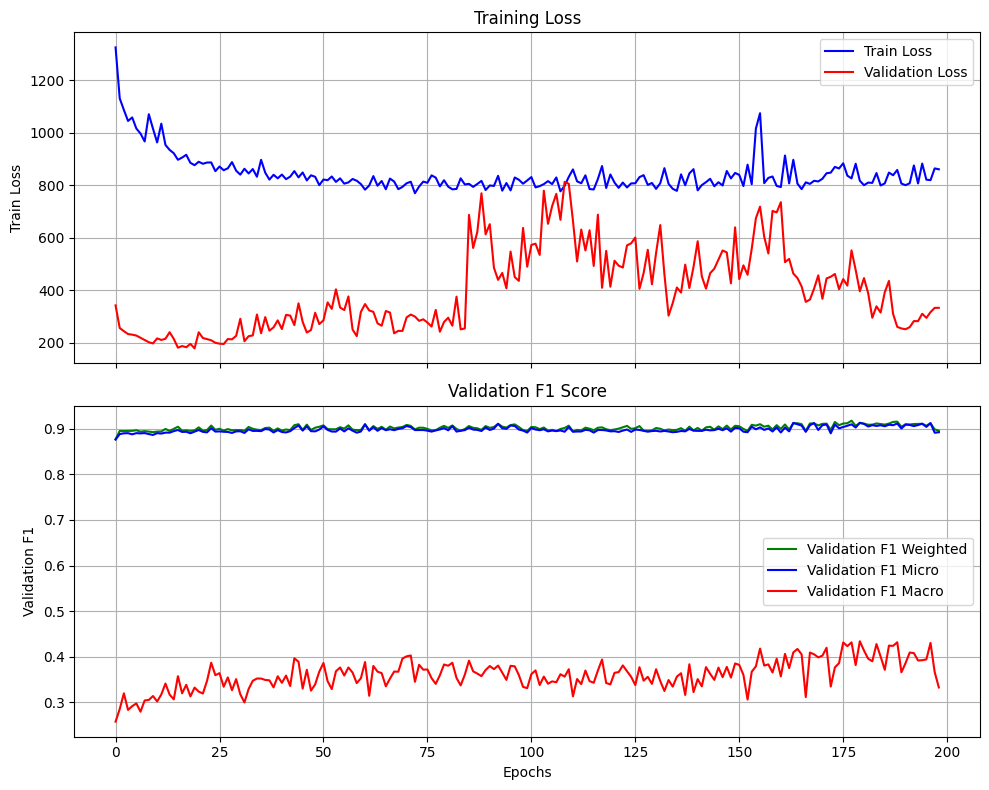

In [33]:
plot_training_process(train_loss_history, val_loss_history, val_f1_history, [])

In [ ]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=num_classes).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path, weights_only=True))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)


    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4)
    print(report)

print("Number of test graphs: ", len(test_graph_dataset))
eval(test_graph_dataset)


Number of test graphs:  278
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_combined_port/best_model_all_raw.pth
inference start


Evaluation:   0%|          | 0/278 [00:00<?, ?it/s]

Test Accuracy: 0.9101
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   36   151    43    89     0     0     0    12     0     0]
 [   13   166    29    62     3     0     0    13     1     0]
 [   23   551   286   605    20     1     0    90     6     0]
 [   67   670   487  1161    68     7     1   229    18     3]
 [   31   290    66    94   305     0     4    95     0     0]
 [   28    58    60   108   113 15296     0    27    10     2]
 [   55     0     1    18   341     0 33115    31    10     0]
 [    0    96    54    99    10     0     0   218    13     0]
 [    0     2     0     0     8     0     0     9    16     0]
 [    0     0     0     1     0     0     0     4     0     1]]
                precision    recall  f1-score   support

      Analysis     0.1423    0.1088    0.1233       331
     Backdoors     0.0837    0.5784    0.1462       287
           DoS     0.2788    0.1808    0.2193      1582
   

In [35]:
def inject_traffic_to_attacker(graph, ratio=0.1, num_injected_nodes=1, is_attack=False):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # 1. Identify attacker nodes
    attacker_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
    attacker_nodes = th.unique(edge_index[:, attacker_edges])
    if attacker_nodes.numel() == 0:
        raise ValueError("No attacker nodes found.")

    # 2. Sample benign edge feature pool
    if is_attack:
        attack_edges = (edge_label != BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[attack_edges]
    else:
        benign_edges = (edge_label == BENIGN_CLASS_LABEL).nonzero(as_tuple=False).squeeze()
        inject_edge_attr_pool = edge_attr[benign_edges]

    # 3. Inject new nodes
    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []

    
    for _ in range(num_to_inject):
        src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes

        dst = attacker_nodes[random.randint(0, len(attacker_nodes) - 1)].item()

        new_edges.append([src, dst])
        attr = inject_edge_attr_pool[random.randint(0, len(inject_edge_attr_pool) - 1)]
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

        # new_graph.first_injected_node_idx = original_num_nodes # Store injected node indices

    return new_graph


In [36]:
# Inject Attack Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=True) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_combined_port/best_model_all_raw.pth
inference start


Test Accuracy: 0.7545
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [ 124  395   93  516  299 4018    3  101    6    5    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[    6    26     7   150     0     4   131     7     0     0]
 [    0    26     7   108     0     6   133     7     0     0]
 [    2    26    70   821     2    19   592    50     0     0]
 

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [37]:
# Inject BENIGN Traffic to Attacker Nodes
injected_graph_dataset = [inject_traffic_to_attacker(g.cpu(), 0.1, num_injected_nodes=1, is_attack=False) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_combined_port/best_model_all_raw.pth
inference start


Test Accuracy: 0.6197
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  37  161  268  630  142  859 3338   86   39    0    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   11    33    12    15     0    20   186    54     0     0]
 [    0    34     9    11     0    15   161    57     0     0]
 [    0    87    76    87     0   118  1047   167     0     0]
 

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [38]:
def inject_random_nodes(graph, ratio=0.1, num_injected_nodes=1):
	edge_index = graph.edge_index.clone()
	edge_attr = graph.edge_attr.clone()
	edge_label = graph.edge_label.clone()
	x = graph.x.clone()

	num_edges = edge_index.size(1)
	feature_dim = graph.x.size(1)

	# 1. Inject new nodes
	original_num_nodes = x.size(0)
	new_node_feats = th.ones((num_injected_nodes, feature_dim))
	x = th.cat([x, new_node_feats], dim=0)

	# 2. Inject random edges
	num_to_inject = max(1, int(ratio * num_edges))
	new_edges = []
	new_attrs = []
	new_labels = []

	for _ in range(num_to_inject):
		src = random.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
		dst = random.randint(0, original_num_nodes - 1)  # to existing nodes

		new_edges.append([src, dst])
		attr = edge_attr[random.randint(0, len(edge_attr) - 1)]  # Randomly sample edge attributes
		new_attrs.append(attr)
		new_labels.append(ADVERSARIAL_CLASS_LABEL)  # Assign benign class label to new edges

	# 3. Merge into graph
	if new_edges:
		new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
		new_attrs = th.stack(new_attrs)
		new_labels = th.tensor(new_labels, dtype=th.long)

		edge_index = th.cat([edge_index, new_edges], dim=1)
		edge_attr = th.cat([edge_attr, new_attrs], dim=0)
		edge_label = th.cat([edge_label, new_labels], dim=0)

	# Create a new graph with the injected nodes and edges
	new_graph = Data(
		edge_index=edge_index,
		edge_attr=edge_attr,
		edge_label=edge_label,
		x=x
	)

	return new_graph

In [39]:
# Inject Random Nodes in the graph
injected_graph_dataset = [inject_random_nodes(g.cpu(), 0.1, num_injected_nodes=1) for g in test_graph_dataset]
eval(injected_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE/logs/UNSW_NB15/window_combined_port/best_model_all_raw.pth
inference start


Evaluation:   0%|          | 0/278 [00:00<?, ?it/s]

Test Accuracy: 0.7679
Adversarial confusion matrix: [[   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [  65  155   99  326  105 1135 3502  128   45    0    0]]
class_map ['Analysis' 'Backdoors' 'DoS' 'Exploits' 'Fuzzers' 'Generic' 'Normal'
 'Reconnaissance' 'Shellcode' 'Worms']
[[   36   133    35   101     0     0    16    10     0     0]
 [   13   147    21    70     3     0    22    11     0     0]
 [   22   491   214   698    16     3    64    69     5     0]
 